# Tuning a `multi_match` `best_fields` query with document expansion by T5 query prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [3]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, optimize_query_mrr100
from qopt.optimize import Config

In [4]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
es = Elasticsearch('http://localhost:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 10

index = 'msmarco-document'
template_id = 'most_fields'

## Baseline evaluation

In [5]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id,
    params={
        'url|boost': 1.0,
        'title|boost': 1.0,
        'body|boost': 1.0,
    })

Evaluation with: MRR@100
Score: 0.2505
CPU times: user 1.62 s, sys: 432 ms, total: 2.06 s
Wall time: 2min 48s


## Query tuning

In [6]:
%%time

_, _, final_params_most_fields, metadata_most_fields = optimize_query_mrr100(es, max_concurrent_searches, index, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 }
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 - iteration 1 scored 0.2050 with: {'url|boost': 9.203162802551738, 'title|boost': 6.579267617383428, 'body|boost': 6.18686851913847}
 - iteration 2 scored 0.1719 with: {'url|boost': 9.990535987925739, 'title|boost': 5.65742859906887, 'body|boost': 1.7320190682727934}
 - iteration 3 scored 0.2413 with: {'url|boost': 2.7212542212191444, 'title|boost': 2.778548730502019, 'body|boost': 4.797412947282158}
 - iteration 4 scored 0.2262 with: {'url|boost': 6.10997646538377, 'title|boost': 6.839796438246055, 'body|boost': 6.873786544022141}
 - iteration 5 scored 0.2429 with: {'url|boost': 3.3287045732527414, 'title|boost': 1.760489564268756, 'body|boost': 7.3138660889722935}
 - iteration 6 scored 0.2667 with: {'url|boost': 0.9181467919482657, 'title|boost': 1.576224508678923, 'body|boost': 9.512391370677935}
 - iteration 7 scored 0.269

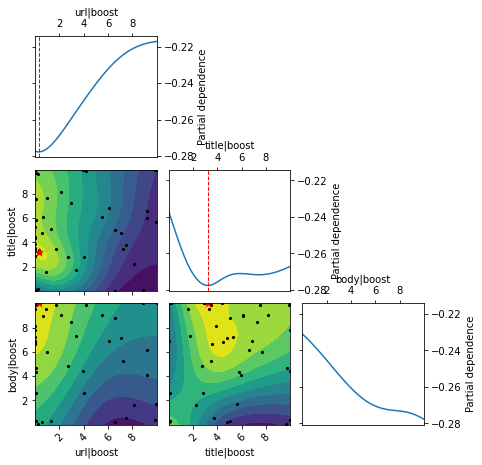

In [7]:
_ = plot_objective(metadata_most_fields, sample_source='result')

In [8]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, params=final_params_most_fields)

Evaluation with: MRR@100
Score: 0.3050
CPU times: user 1.81 s, sys: 571 ms, total: 2.38 s
Wall time: 6min 13s
